/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Best Threshold for Random Forest: 0.99

=== Injury Risk Classification Results ===

Logistic Regression:
Accuracy: 0.7200
Precision: 0.7000
Recall: 0.7568
ROC-AUC: 0.7240

Random Forest (Optimized):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC-AUC: 1.0000


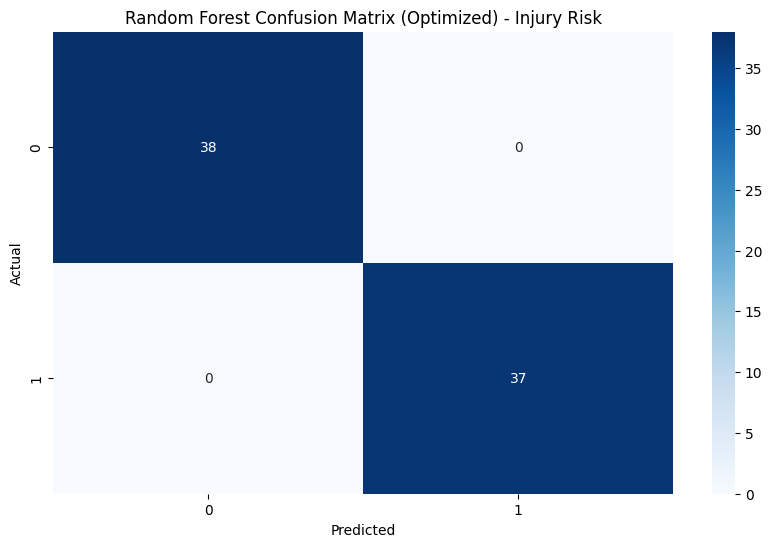

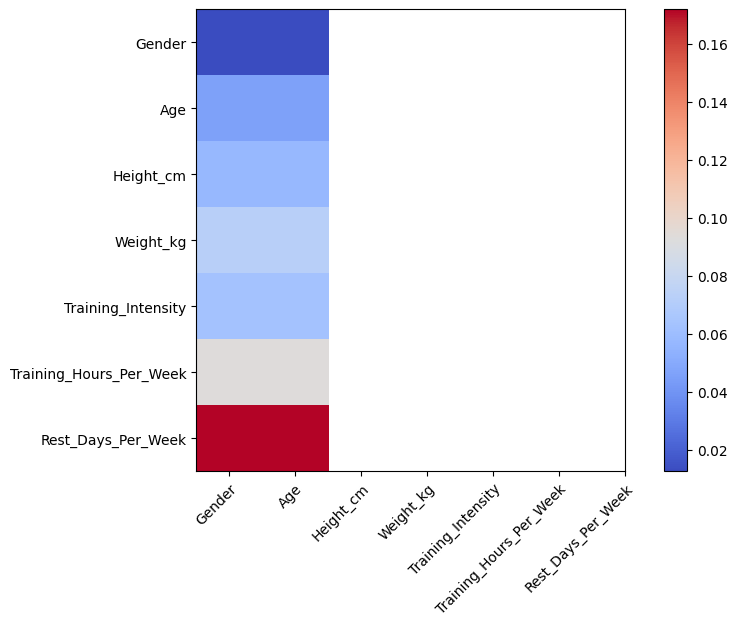


=== Recovery Time Prediction Results ===

Linear Regression:
RMSE: 2.6822
MAE: 2.1249
R2: 0.0340

Random Forest:
RMSE: 2.5628
MAE: 1.9378
R2: 0.1181

Gradient Boosting:
RMSE: 2.6294
MAE: 2.1073
R2: 0.0717


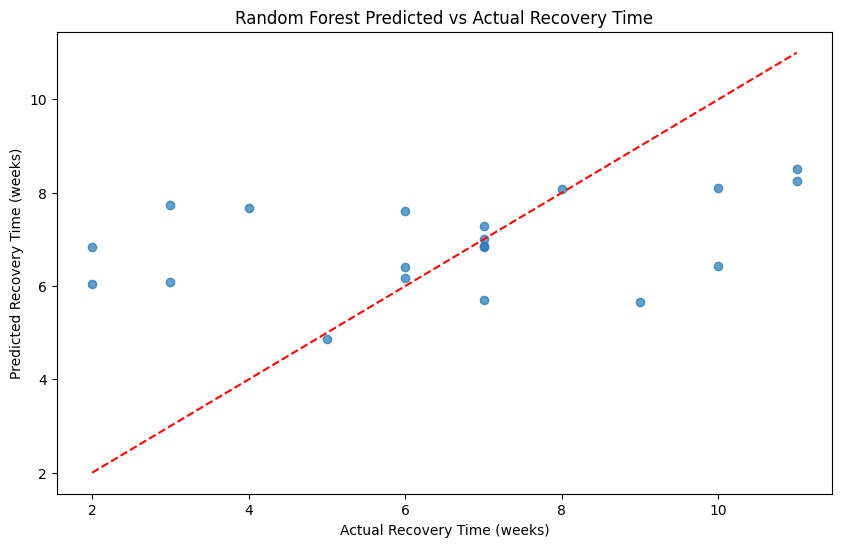

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===========================================
# SECTION 1: ACL INJURY RISK CLASSIFICATION
# ===========================================

# Load dataset
injury_df = pd.read_excel("AI & Machine Learning 1 - Injury Risk.xlsx")

# Manual Oversampling for Injury Cases
injury_cases = injury_df[injury_df["Injury_Indicator"] == 1]
no_injury_cases = injury_df[injury_df["Injury_Indicator"] == 0]

oversampled_injury = injury_cases.sample(len(no_injury_cases), replace=True, random_state=42)
balanced_df = pd.concat([oversampled_injury, no_injury_cases])

# Features and target
X_injury = balanced_df.drop(columns=["Injury_Indicator"])
y_injury = balanced_df["Injury_Indicator"]

# Encode categorical variables
if "Gender" in X_injury.columns:
    X_injury["Gender"] = LabelEncoder().fit_transform(X_injury["Gender"])

# Train/test split
X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(
    X_injury, y_injury, test_size=0.2, random_state=42, stratify=y_injury
)

# Models with class_weight
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# Train models
logreg.fit(X_train_injury, y_train_injury)
rf_clf.fit(X_train_injury, y_train_injury)

# ==========================
# Automatic Threshold Tuning
# ==========================
y_prob_rf = rf_clf.predict_proba(X_test_injury)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_injury, y_prob_rf)

# Choose threshold with best F1-score tradeoff
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest Threshold for Random Forest: {best_threshold:.2f}")

def predict_with_threshold(model, X, threshold):
    y_prob = model.predict_proba(X)[:, 1]
    return (y_prob >= threshold).astype(int)

# Evaluation function for classification
def evaluate_classifier(model, X_test, y_test, threshold=None):
    if threshold:
        y_pred = predict_with_threshold(model, X_test, threshold)
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "ConfusionMatrix": confusion_matrix(y_test, y_pred)
    }

# Evaluate models
results_injury = {
    "Logistic Regression": evaluate_classifier(logreg, X_test_injury, y_test_injury),
    "Random Forest (Optimized)": evaluate_classifier(rf_clf, X_test_injury, y_test_injury, threshold=best_threshold)
}

# Print results
print("\n=== Injury Risk Classification Results ===")
for model, metrics in results_injury.items():
    print(f"\n{model}:")
    for k, v in metrics.items():
        if k != "ConfusionMatrix":
            print(f"{k}: {v:.4f}")

# Confusion Matrix (Random Forest with threshold tuning)
cm = results_injury["Random Forest (Optimized)"]["ConfusionMatrix"]
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix (Optimized) - Injury Risk")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("Fig_15.pdf", dpi=600, bbox_inches='tight')
plt.show()

# SHAP Feature Importance (Random Forest)
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test_injury)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_matrix = np.abs(shap_values[1]).mean(0)
else:
    shap_matrix = np.abs(shap_values).mean(0)

feature_names = X_test_injury.columns
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(shap_matrix, cmap="coolwarm")

ax.set_xticks(range(len(feature_names)))
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
plt.savefig("Fig_16.pdf", dpi=600, bbox_inches="tight")
plt.show()



# ===========================================
# SECTION 2: ACL RECOVERY TIME PREDICTION
# ===========================================

# Load dataset
recovery_df = pd.read_excel("AI & Machine Learning 2 - Recovery Time.xlsx")
recovery_df = recovery_df.drop(columns=[col for col in recovery_df.columns if "Unnamed" in col], errors='ignore')

# Features and target
X_recovery = recovery_df.drop(columns=["Rehabilitation_Time_weeks"])
y_recovery = recovery_df["Rehabilitation_Time_weeks"]

# Encode categorical variables
for col in X_recovery.select_dtypes(include=["object"]).columns:
    X_recovery[col] = LabelEncoder().fit_transform(X_recovery[col])

# Scale features
scaler = StandardScaler()
X_recovery_scaled = scaler.fit_transform(X_recovery)

# Train/test split
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(
    X_recovery_scaled, y_recovery, test_size=0.2, random_state=42
)

# Models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
gb_reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Train models
lin_reg.fit(X_train_rec, y_train_rec)
rf_reg.fit(X_train_rec, y_train_rec)
gb_reg.fit(X_train_rec, y_train_rec)

# Evaluation function for regression
def evaluate_regressor(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Predictions": y_pred
    }

# Evaluate models
results_recovery = {
    "Linear Regression": evaluate_regressor(lin_reg, X_test_rec, y_test_rec),
    "Random Forest": evaluate_regressor(rf_reg, X_test_rec, y_test_rec),
    "Gradient Boosting": evaluate_regressor(gb_reg, X_test_rec, y_test_rec)
}

# Print results
print("\n=== Recovery Time Prediction Results ===")
for model, metrics in results_recovery.items():
    print(f"\n{model}:")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"R2: {metrics['R2']:.4f}")

# Predicted vs Actual (Random Forest)
y_pred_rf = results_recovery["Random Forest"]["Predictions"]
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rec, y_pred_rf, alpha=0.7)
plt.plot([y_test_rec.min(), y_test_rec.max()], [y_test_rec.min(), y_test_rec.max()], 'r--')
plt.xlabel("Actual Recovery Time (weeks)")
plt.ylabel("Predicted Recovery Time (weeks)")
plt.title("Random Forest Predicted vs Actual Recovery Time")
plt.savefig("Fig_17.pdf", dpi=600, bbox_inches='tight')
plt.show()
